<a href="https://colab.research.google.com/github/tibebu-sime/sales-predictions/blob/main/salespredictions_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task
This project is meant to build a sales prediction model for a retail store. It is pretty obvious that sales forecasting is an essential task for the management of a store. 

**Attributes information:**
1. Item_Identifier: Unique product ID
2. Item_Weight: Weight of product
3. Item_Fat_Content: Whether the product is low fat or not
4. Item_Visibility: The % of total display area of all products in a store allocated to the particular product
5. Item_Type: The category to which the product belongs
6. Item_MRP: Maximum Retail Price (list price) of the product
7. Outlet_Identifier: Unique store ID
8. Outlet_Establishment_Year: The year in which store was established
9. Outlet_Size: The size of the store in terms of ground area covered
10. Outlet_Location_Type: The type of city in which the store is located
11. Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket
12. Item_Outlet_Sales: Sales of the product in the particular store. This is the outcome variable to be predicted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score


In [ ]:
filename = '/content/drive/MyDrive/CodingDojo/Week2_PandasforDataManipulation/Exercises_and_Homework/sales_predictions.csv'
sales_data = pd.read_csv(filename)
sales_data.head()

In [ ]:
sales_data.info()

In [7]:
#Method 2: Check and detect the presence of missing values using the isnull() function
sales_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Based on the concise summary of the dataset, there are missing values within two columns, namely Item_Weight and Outlet_Size. I will be filling the missing values within the Item_Weight column by the mean of this same column but imputing the missing values within the Outlet_Size column using the Most Freuquent Imputation technique which works well with both strings or categorical features and numerical representations.  

References: 
1. https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
2. https://jamesrledoux.com/code/imputation
3. https://stackoverflow.com/questions/32617811/imputation-of-missing-values-for-categories-in-pandas
4. https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114


In [ ]:
# Fill the null values within the Item_Weight column with the mean of this column
sales_data['Item_Weight'] = sales_data['Item_Weight'].fillna(sales_data['Item_Weight'].mean())
sales_data.head()

In [ ]:
# Check and detect the presence of missing values using the isnull() function again
sales_data.isnull().sum()

In [ ]:
# Only the Outlet Size column has missing values. Impute them with most frequent values
# https://www.geeksforgeeks.org/how-to-fill-nan-values-with-mean-in-pandas/

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
fitted_data = imputer.fit_transform(sales_data) # Returns NumPy array 

sales_data = pd.DataFrame(fitted_data, index=sales_data.index, columns=sales_data.columns)
sales_data.head()


In [ ]:
# Check and detect the presence of missing values using the isnull() function again
sales_data.isnull().sum()

In [ ]:
# Checking the unique appearances of each column in the dataset and replace the 
# inconsistencies 
sales_data.apply(lambda x: x.unique())

In [ ]:
# There are data entry inconsistencies in the Item_Fat_Content, so I need to
# replace them. 
sales_data['Item_Fat_Content'].unique()

In [ ]:
sales_data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}, inplace=True)
sales_data['Item_Fat_Content'].unique()

#Data Visualization 

In [24]:
# Changing the data types of the columns whose data types have been modified when
# the missing values in the Outlet_Size column were imputed. 
# Reference: https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

sales_data = sales_data.astype({'Item_Weight': float, 
                                'Item_Visibility': float,
                                'Item_MRP': float,
                                'Outlet_Establishment_Year': int,
                                'Item_Outlet_Sales': float
                                               })

In [25]:
# Checking the data types 
sales_data.dtypes 

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [26]:
# Displaying the descriptive statistics of the dataframe 
sales_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


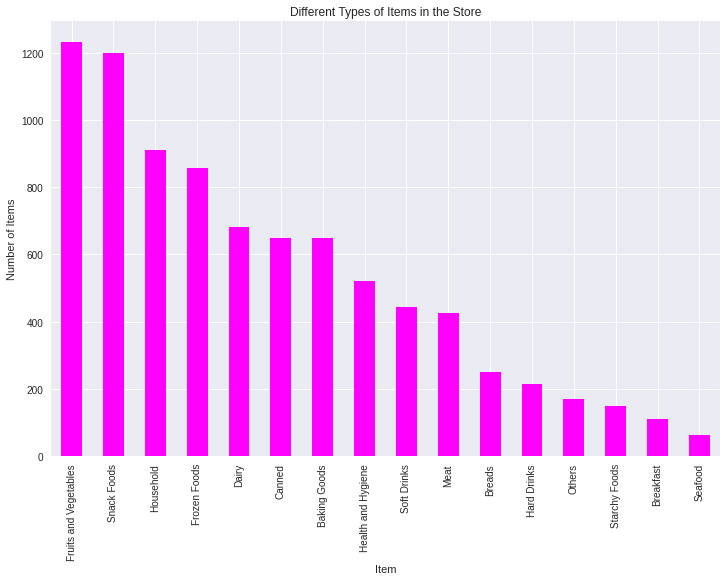

In [28]:
# Different types of items available in the store 
plt.style.use('seaborn')
itemTypes = sales_data['Item_Type'].value_counts()
itemTypes.plot(kind='bar', color='magenta', figsize=(12, 8))
plt.title('Different Types of Items in the Store')
plt.xlabel('Item')
plt.ylabel('Number of Items')
plt.show()

In [ ]:
# the average item sales by the location types of the store 
sales_data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean()

In [ ]:
# the average item sales by the types of store 
sales_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean()

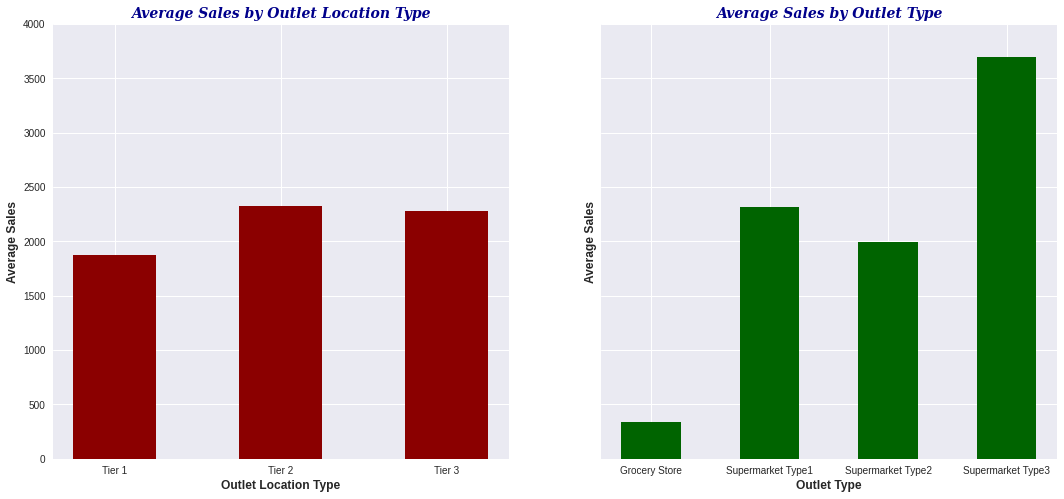

In [ ]:
x0 = sales_data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().index
y0 = sales_data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().values

x1 = sales_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().index
y1 = sales_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().values

plt.style.use('seaborn')

font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 8))
axs[0].bar(x0, y0, width=0.5, color='darkred')
axs[0].set_title('Average Sales by Outlet Location Type', fontdict=font)
axs[0].set_ylim(0, 2500)
#Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tick_params.html
axs[0].tick_params(axis='both', labelsize=10)  
axs[0].set_xlabel('Outlet Location Type', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Average Sales', fontsize=12, fontweight='bold')

axs[1].bar(x1, y1, width=0.5, color='darkgreen')
axs[1].set_title('Average Sales by Outlet Type', fontdict=font)
axs[1].set_ylim(0, 4000)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_xlabel('Outlet Type', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Average Sales', fontsize=12, fontweight='bold')

plt.show()

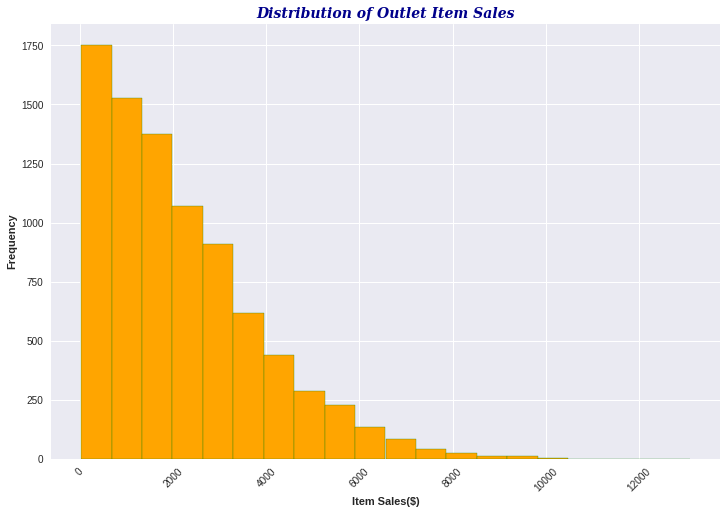

In [ ]:
# Visualize the distribution of the item sales 
sales_data['Item_Outlet_Sales'].hist(bins=20, color='orange', edgecolor='green', figsize=(12, 8))
plt.xticks(rotation=45)
plt.ticklabel_format(useOffset=False, style='plain')

font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }

plt.xlabel('Item Sales($)', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Distribution of Outlet Item Sales', fontdict=font)
plt.show()

As we can see, the sales distribution deviates from the normal distribution and is skewed to the right. 

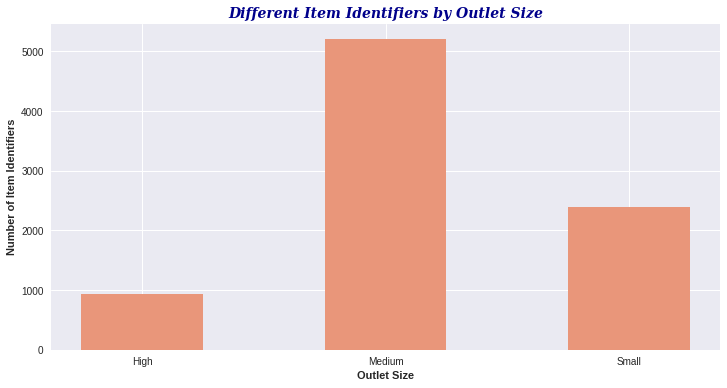

In [ ]:
# Number of different item identifiers by the store size
# Reference 1: https://pythonbasics.org/matplotlib-bar-chart/
# Reference 2: https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
# Reference 3: https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/

sales_data.groupby('Outlet_Size')['Item_Identifier'].count()
x = sales_data.groupby('Outlet_Size')['Item_Identifier'].count().index
y = sales_data.groupby('Outlet_Size')['Item_Identifier'].count().values
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }
plt.figure(figsize=(12, 6))       
plt.bar(x, y, color='darksalmon', width=0.5)
plt.title('Different Item Identifiers by Outlet Size', fontdict=font)
plt.xlabel('Outlet Size', fontweight='bold')
plt.ylabel('Number of Item Identifiers', fontweight='bold')
plt.show()


In [ ]:
# Check different of types of items available in the whole store 
# Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html

sales_data.value_counts(subset='Item_Identifier')

Item_Identifier
FDW13    10
FDG33    10
NCQ06     9
FDF56     9
FDX20     9
         ..
FDC23     1
FDQ60     1
FDK57     1
FDO33     1
DRF48     1
Length: 1559, dtype: int64

In [ ]:
#Method 2 - the relative frequency of each unique item
sales_data['Item_Identifier'].value_counts()
sales_data['Item_Identifier'].value_counts(normalize=True)

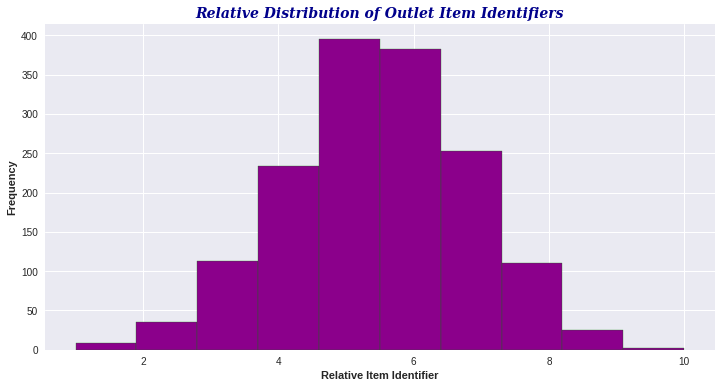

In [ ]:
sales_data['Item_Identifier'].value_counts().hist(color='darkmagenta', edgecolor='g', figsize=(12, 6))
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }
plt.title('Relative Distribution of Outlet Item Identifiers', fontdict=font)
plt.xlabel('Relative Item Identifier', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

In [ ]:
# Different varieties of fats in food items by the Outlet Type
# Reference: https://www.pythoncharts.com/matplotlib/grouped-bar-charts-matplotlib/
# https://kontext.tech/column/code-snippets/399/pandas-dataframe-plot-bar-chart

fats = sales_data.groupby('Outlet_Size')['Item_Fat_Content'].value_counts()
fats



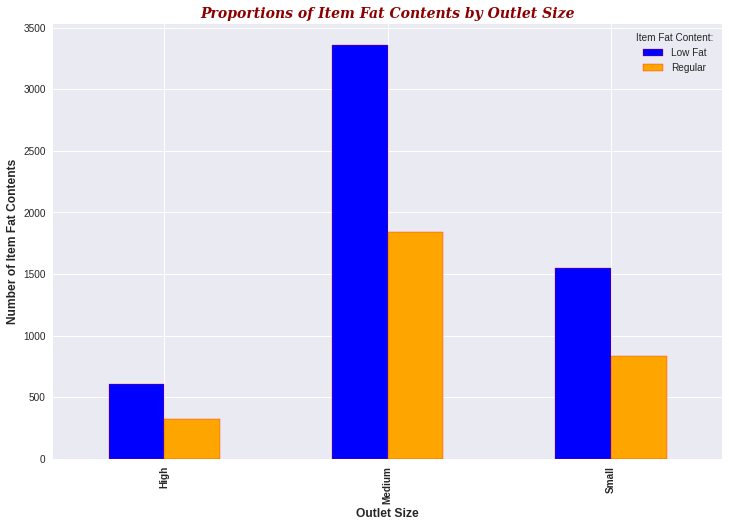

In [ ]:
# Reference 1: https://kontext.tech/column/code-snippets/399/pandas-dataframe-plot-bar-chart
# Reference 2: https://stackoverflow.com/questions/30873523/how-can-i-change-the-color-of-a-grouped-bar-plot-in-pandas
# Reference 3: https://www.datasciencemadesimple.com/bar-plot-bar-chart-in-python-legend-using-matplotlib/

fats.unstack().plot(kind='bar', color=['blue', 'orange'], edgecolor='red', figsize=(12, 8))
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkRed'
        }
plt.xlabel('Outlet Size', fontsize=12, fontweight='bold')
plt.ylabel('Number of Item Fat Contents', fontsize=12, fontweight='bold')
plt.xticks(fontweight='bold')
plt.title('Proportions of Item Fat Contents by Outlet Size', fontdict=font)
plt.legend(['Low Fat', 'Regular'], title='Item Fat Content:', fontsize=10)
plt.show()


#Correlation

In [29]:
# Plotting the correlation between quantitative variables using heatmaps 
correlation = sales_data.corr()
correlation.sort_values(by='Item_Outlet_Sales') # Sort them by the Sales 

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Visibility,-0.012049,1.000000,-0.001315,-0.074834,-0.128625
Outlet_Establishment_Year,-0.008301,-0.074834,0.005020,1.000000,-0.049135
Item_Weight,1.000000,-0.012049,0.024756,-0.008301,0.011550
Item_MRP,0.024756,-0.001315,1.000000,0.005020,0.567574
Item_Outlet_Sales,0.011550,-0.128625,0.567574,-0.049135,1.000000


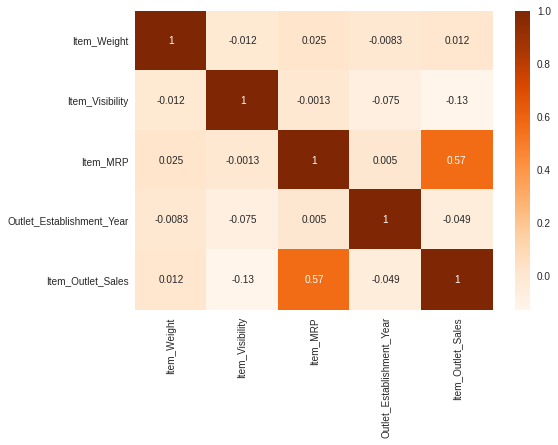

In [30]:
sns.heatmap(correlation, cmap='Oranges', annot=True)
plt.show()

From the above heatmap, there is a moderate positive relationship between the Item MRP and Item Outlet Sales as the correlation coefficient is equal to 0.57.

#Boxplot
Graph boxplots to show the distribution of the continuous Item Outlet Sales feature for the different types of Outlet Location.

In [ ]:
tier1 = sales_data['Outlet_Location_Type'] == 'Tier 1'
sales_data[tier1]

In [ ]:
tier2 = sales_data['Outlet_Location_Type'] == 'Tier 2'
sales_data[tier2]

In [ ]:
tier3 = sales_data['Outlet_Location_Type'] == 'Tier 3'
sales_data[tier3]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


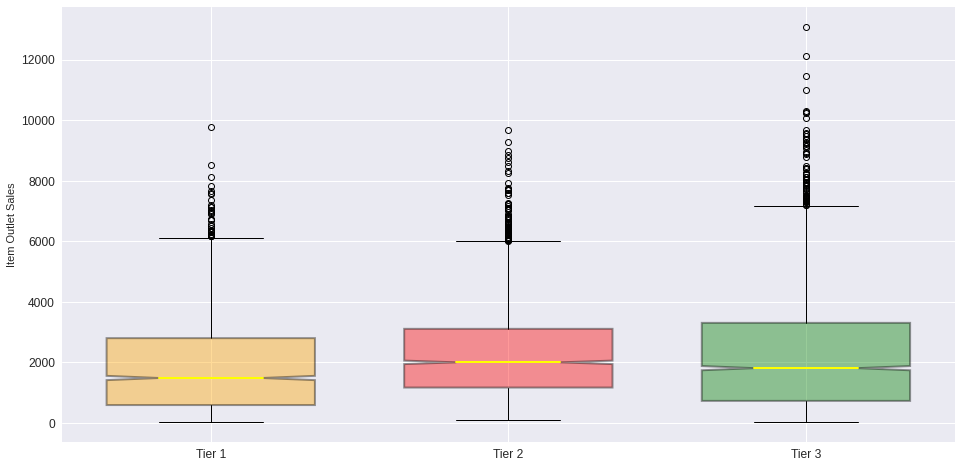

In [38]:
x1 = sales_data[tier1]['Item_Outlet_Sales'].values
x2 = sales_data[tier2]['Item_Outlet_Sales'].values
x3 = sales_data[tier3]['Item_Outlet_Sales'].values

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
boxplots = ax.boxplot([x1, x2, x3], 
           labels=['Tier 1', 'Tier 2', 'Tier 3'], 
           notch =True,
           widths = 0.7,
           patch_artist =True,
           medianprops = dict(linestyle ='-', linewidth=2, color='yellow'),
           boxprops = dict(linestyle ='--', linewidth=2, color='black', facecolor='blue', alpha=0.4)
           )

boxplot1 = boxplots['boxes'][0]
boxplot2 = boxplots['boxes'][1]
boxplot3 = boxplots['boxes'][2]
boxplot1.set_facecolor('orange')
boxplot2.set_facecolor('red')
boxplot3.set_facecolor('green')


ax.set_ylabel('Item Outlet Sales')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#Feature Engineering and Data Modeling 

In [129]:
# Split the columns of the data into numerical and categorical variables
categorical_variables = sales_data.select_dtypes(include=object)
categorical_variables.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,Medium,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1


In [130]:
numerical_variables = sales_data.select_dtypes(exclude=object)
numerical_variables.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228
2,17.50,0.016760,141.6180,1999,2097.2700
3,19.20,0.000000,182.0950,1998,732.3800
4,8.93,0.000000,53.8614,1987,994.7052


In [131]:
# Tranforming categorical variables into numerical format using Dummy Label
categorical_variables = pd.get_dummies(categorical_variables, drop_first=True)
categorical_variables.head()

,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,Item_Identifier_DRB25,Item_Identifier_DRB48,Item_Identifier_DRC01,Item_Identifier_DRC12,Item_Identifier_DRC13,Item_Identifier_DRC24,Item_Identifier_DRC25,Item_Identifier_DRC27,Item_Identifier_DRC36,Item_Identifier_DRC49,Item_Identifier_DRD01,Item_Identifier_DRD12,Item_Identifier_DRD13,Item_Identifier_DRD15,Item_Identifier_DRD24,Item_Identifier_DRD25,Item_Identifier_DRD27,Item_Identifier_DRD37,Item_Identifier_DRD49,Item_Identifier_DRD60,Item_Identifier_DRE01,Item_Identifier_DRE03,Item_Identifier_DRE12,Item_Identifier_DRE13,Item_Identifier_DRE15,Item_Identifier_DRE25,Item_Identifier_DRE27,Item_Identifier_DRE37,Item_Identifier_DRE48,Item_Identifier_DRE49,Item_Identifier_DRE60,Item_Identifier_DRF01,Item_Identifier_DRF03,Item_Identifier_DRF13,Item_Identifier_DRF15,...,Item_Identifier_NCZ17,Item_Identifier_NCZ18,Item_Identifier_NCZ29,Item_Identifier_NCZ30,Item_Identifier_NCZ41,Item_Identifier_NCZ42,Item_Identifier_NCZ53,Item_Identifier_NCZ54,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [132]:
# Combine the encoded categorial variables and numerical variables 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

combined_data = pd.concat([categorical_variables, numerical_variables], axis=1)
combined_data.head()

,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,Item_Identifier_DRB25,Item_Identifier_DRB48,Item_Identifier_DRC01,Item_Identifier_DRC12,Item_Identifier_DRC13,Item_Identifier_DRC24,Item_Identifier_DRC25,Item_Identifier_DRC27,Item_Identifier_DRC36,Item_Identifier_DRC49,Item_Identifier_DRD01,Item_Identifier_DRD12,Item_Identifier_DRD13,Item_Identifier_DRD15,Item_Identifier_DRD24,Item_Identifier_DRD25,Item_Identifier_DRD27,Item_Identifier_DRD37,Item_Identifier_DRD49,Item_Identifier_DRD60,Item_Identifier_DRE01,Item_Identifier_DRE03,Item_Identifier_DRE12,Item_Identifier_DRE13,Item_Identifier_DRE15,Item_Identifier_DRE25,Item_Identifier_DRE27,Item_Identifier_DRE37,Item_Identifier_DRE48,Item_Identifier_DRE49,Item_Identifier_DRE60,Item_Identifier_DRF01,Item_Identifier_DRF03,Item_Identifier_DRF13,Item_Identifier_DRF15,...,Item_Identifier_NCZ42,Item_Identifier_NCZ53,Item_Identifier_NCZ54,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,9.30,0.016047,249.8092,1999,3735.1380
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,5.92,0.019278,48.2692,2009,443.4228
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,17.50,0.016760,141.6180,1999,2097.2700
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,19.20,0.000000,182.0950,1998,732.3800
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,8.93,0.000000,53.8614,1987,994.7052


In [ ]:
# Split the data into feature matrix and target vector 
X = combined_data.drop('Item_Outlet_Sales', axis = 1).values
X

In [ ]:
y = combined_data['Item_Outlet_Sales'].values
y

In [ ]:
# Make an instance of the model and fit the data onto the model
reg = LinearRegression()
reg.fit(X, y)

In [ ]:
# Make predictions 
predictions = reg.predict(X)
predictions

# Evaluating the model performance 


In [138]:
# Coefficient of Determination R-Squared
score = reg.score(X, y)
print("Coefficient of Determination R^2:", score)

Coefficient of Determination R^2: 0.6413215981268732


In [139]:
# Method 2
score = r2_score(y, predictions)
score

0.6413215981268732

In [ ]:
# Mean Squared Error 
MSE = mean_squared_error(y, predictions)
MSE

In [141]:
# Root MSE 
RMSE = mean_squared_error(y, predictions, squared=False)
RMSE

1021.9586608651576

In [142]:
# Mean Absolute Error
MAE = mean_absolute_error(y, predictions)
MAE

764.0047249560014